# Introduction

This is a simple fork of my previous kernel (https://www.kaggle.com/taindow/pytorch-efficientnet-b0), except here we make use of ResNeXt and "weakly supervised pre-training" as opposed to EfficientNet. See https://github.com/facebookresearch/WSL-Images for model information. Note due to the number of parameters a single sweep of the data will take approx. 4-5h.

# Sources

Windowing functions for pre-processed data taken from the following:

- https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing 

# Parameters

In [1]:
# Input

dir_csv = '../input/rsna-intracranial-hemorrhage-detection'
dir_train_img = '../input/rsna-train-stage-1-images-png-224x/stage_1_train_png_224x'
dir_test_img = '../input/rsna-test-stage-1-images-png-224x/stage_1_test_png_224x'


In [2]:

# Parameters

n_classes = 6
n_epochs = 1
batch_size = 64


# Setup

Need to grab a couple of extra libraries

- Nvidia Apex for mixed precision training (https://github.com/NVIDIA/apex)

In [3]:
# Installing useful libraries

!git clone https://github.com/NVIDIA/apex && cd apex && pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./
    

Cloning into 'apex'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 5440 (delta 3), reused 6 (delta 3), pack-reused 5422
Receiving objects: 100% (5440/5440), 13.33 MiB | 0 bytes/s, done.
Resolving deltas: 100% (3514/3514), done.
/opt/conda/lib/python3.6/site-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-lgiieec8
Created temporary directory: /tmp/pip-req-tracker-os19xyna
Created requirements tracker '/tmp/pip-req-tracker-os19xyna'
Created temporary directory: /tmp/pip-install-1yqj4w4j
Processing /kaggle/working/apex
  Created temporary directory: /tmp/pip-req-build-3fyxjpf5
  Added file:///kaggle/working/apex to build tracker '/tmp/pip-req-tracker-os19xyna'
    Runnin

In [4]:
# Libraries

from apex import amp
import os
import cv2
import glob
import pydicom
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from albumentations import Compose, ShiftScaleRotate, Resize
from albumentations.pytorch import ToTensor
from torch.utils.data import Dataset
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

In [5]:

# Functions

class IntracranialDataset(Dataset):

    def __init__(self, csv_file, path, labels, transform=None):
        
        self.path = path
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.labels = labels

    def __len__(self):
        
        return len(self.data)

    def __getitem__(self, idx):
        
        img_name = os.path.join(self.path, self.data.loc[idx, 'Image'] + '.png')
        img = cv2.imread(img_name)   
        
        if self.transform:       
            
            augmented = self.transform(image=img)
            img = augmented['image']   
            
        if self.labels:
            
            labels = torch.tensor(
                self.data.loc[idx, ['epidural', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural', 'any']])
            return {'image': img, 'labels': labels}    
        
        else:      
            
            return {'image': img}
    
    


# CSV

In [6]:
# CSVs

train = pd.read_csv(os.path.join(dir_csv, 'stage_1_train.csv'))
test = pd.read_csv(os.path.join(dir_csv, 'stage_1_sample_submission.csv'))

In [7]:

# Split train out into row per image and save a sample

train[['ID', 'Image', 'Diagnosis']] = train['ID'].str.split('_', expand=True)
train = train[['Image', 'Diagnosis', 'Label']]
train.drop_duplicates(inplace=True)
train = train.pivot(index='Image', columns='Diagnosis', values='Label').reset_index()
train['Image'] = 'ID_' + train['Image']
train.head()

Diagnosis,Image,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
0,ID_000039fa0,0,0,0,0,0,0
1,ID_00005679d,0,0,0,0,0,0
2,ID_00008ce3c,0,0,0,0,0,0
3,ID_0000950d7,0,0,0,0,0,0
4,ID_0000aee4b,0,0,0,0,0,0


In [8]:
# Some files didn't contain legitimate images, so we need to remove them

png = glob.glob(os.path.join(dir_train_img, '*.png'))
png = [os.path.basename(png)[:-4] for png in png]
png = np.array(png)

train = train[train['Image'].isin(png)]
train.to_csv('train.csv', index=False)

In [9]:
# Also prepare the test data

test[['ID','Image','Diagnosis']] = test['ID'].str.split('_', expand=True)
test['Image'] = 'ID_' + test['Image']
test = test[['Image', 'Label']]
test.drop_duplicates(inplace=True)

test.to_csv('test.csv', index=False)

# DataLoaders

In [10]:
# Data loaders

transform_train = Compose([
    ShiftScaleRotate(),
    ToTensor()
])

transform_test= Compose([
    ToTensor()
])

train_dataset = IntracranialDataset(
    csv_file='train.csv', path=dir_train_img, transform=transform_train, labels=True)

test_dataset = IntracranialDataset(
    csv_file='test.csv', path=dir_test_img, transform=transform_test, labels=False)

data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
data_loader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

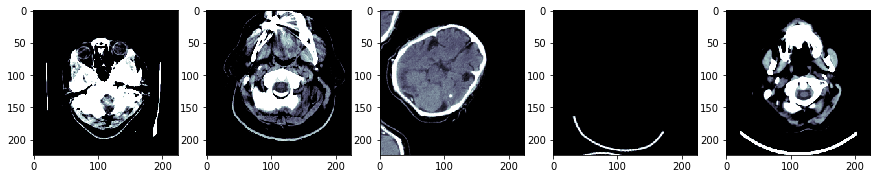

In [11]:
# Plot train example

batch = next(iter(data_loader_train))
fig, axs = plt.subplots(1, 5, figsize=(15,5))

for i in np.arange(5):
    
    axs[i].imshow(np.transpose(batch['image'][i].numpy(), (1,2,0))[:,:,0], cmap=plt.cm.bone)


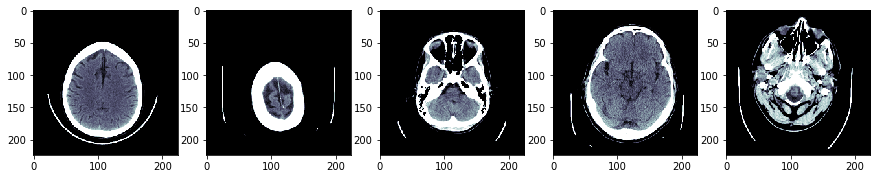

In [12]:
# Plot test example

batch = next(iter(data_loader_test))
fig, axs = plt.subplots(1, 5, figsize=(15,5))

for i in np.arange(5):
    
    axs[i].imshow(np.transpose(batch['image'][i].numpy(), (1,2,0))[:,:,0], cmap=plt.cm.bone)


# Model

In [13]:
# Model

device = torch.device("cuda:0")
model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
model.fc = torch.nn.Linear(2048, n_classes)

model.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
plist = [{'params': model.parameters(), 'lr': 2e-5}]
optimizer = optim.Adam(plist, lr=2e-5)

model, optimizer = amp.initialize(model, optimizer, opt_level="O1")


Downloading: "https://github.com/facebookresearch/WSL-Images/archive/master.zip" to /tmp/.cache/torch/hub/master.zip
Downloading: "https://download.pytorch.org/models/ig_resnext101_32x8-c38310e5.pth" to /tmp/.cache/torch/checkpoints/ig_resnext101_32x8-c38310e5.pth
100%|██████████| 340M/340M [00:23<00:00, 15.1MB/s]


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


# Training

In [14]:
# Train


for epoch in range(n_epochs):
    
    print('Epoch {}/{}'.format(epoch, n_epochs - 1))
    print('-' * 10)

    model.train()    
    tr_loss = 0
    
    tk0 = tqdm(data_loader_train, desc="Iteration")

    for step, batch in enumerate(tk0):

        inputs = batch["image"]
        labels = batch["labels"]

        inputs = inputs.to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.float)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()

        tr_loss += loss.item()

        optimizer.step()
        optimizer.zero_grad()

    epoch_loss = tr_loss / len(data_loader_train)
    print('Training Loss: {:.4f}'.format(epoch_loss))

Epoch 0/0
----------


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0

Training Loss: 0.0788


# Inference

In [15]:
# Inference

for param in model.parameters():
    param.requires_grad = False

model.eval()

test_pred = np.zeros((len(test_dataset) * n_classes, 1))

for i, x_batch in enumerate(tqdm(data_loader_test)):
    
    x_batch = x_batch["image"]
    x_batch = x_batch.to(device, dtype=torch.float)
    
    with torch.no_grad():
        
        pred = model(x_batch)
        
        test_pred[(i * batch_size * n_classes):((i + 1) * batch_size * n_classes)] = torch.sigmoid(
            pred).detach().cpu().reshape((len(x_batch) * n_classes, 1))

# Submission

In [16]:
# Submission

submission =  pd.read_csv(os.path.join(dir_csv, 'stage_1_sample_submission.csv'))
submission = pd.concat([submission.drop(columns=['Label']), pd.DataFrame(test_pred)], axis=1)
submission.columns = ['ID', 'Label']

submission.to_csv('submission.csv', index=False)
submission.head()

,ID,Label
0,ID_28fbab7eb_epidural,0.000142
1,ID_28fbab7eb_intraparenchymal,0.000197
2,ID_28fbab7eb_intraventricular,0.000023
3,ID_28fbab7eb_subarachnoid,0.000807
4,ID_28fbab7eb_subdural,0.000538


# Clean Up

Have to clean up since Kaggle limits the number of files that can be output from a kernel

In [17]:
!rm -rf /kaggle/working/apex
!rm test.csv
!rm train.csv